In [173]:
import numpy.random
import scipy
import scipy.optimize
import scipy.constants
import math
import numpy 
import uncertainties
import uncertainties.unumpy 

import matplotlib.axes
import matplotlib.pyplot
import scipy.misc
import scipy.special
import scipy.stats
from random import *
from scipy.special import xlogy
import sys
from scipy.stats import norm

import pandas as pd

from scipy.optimize import curve_fit


from math import *

from scipy.optimize import curve_fit

files = numpy.array([
    'runFile_GaAs.out',
    'runFile_HgCdTe.out',
    'runFile_InAsSb.out',
    'runFile_InAs.out',
    'runFile_InSbBi_5Bi.out',
    'runFile_InSbBi_05Bi.out',
    'runFile_InSb.out',
    'runFile_Si.out'])

nice_semiconductor_names = numpy.array(['$GaAs$' , '$Hg_{0.7}Cd_{0.3}Te$' , '$InAs_{0.91}Sb_{0.09}$' , '$InAs$' , '$InSb_{0.5}Bi_{0.5}$' , '$InSb_{0.95}Bi_{0.05}$' ,'InSb', '$Si$'])

import periodictable

from periodictable import elements as periodictable_elements

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import brewer2mpl

bmap = brewer2mpl.get_map('Paired', 'qualitative', 10)
colors = bmap.mpl_colors

import periodictable
from periodictable import elements as periodictable_elements
from math import *

In [174]:
# FOR THIS ONE, THE FLUX WAS 10^12 per second and irradiation was conducted for 30 seconds
time = 30
flux = 10**12
total_fluence = time*flux
numParticles_fisp = total_fluence


# EXPERIMENT PARAMETERS

# in cm^3, 1cm x 1cm x 0.5 mm (0.05 cm)
volume = 1*1*0.05
chris_angle = 45*2*math.pi/360
numParticles_expr_100kRAD =  7.5*10**11
numParticles_expr_100kRAD_45deg =  7.5*10**11*math.cos(chris_angle)
CALC_convertToEXPR_100kRAD_perCM3 = (numParticles_expr_100kRAD/numParticles_fisp)/volume
CALC_convertToEXPR_100kRAD_perCM3_45edg = (numParticles_expr_100kRAD_45deg/numParticles_fisp)/volume
CALC_convertToEXPR_1MRAD_perCM3 = (numParticles_expr_100kRAD*10/numParticles_fisp)/volume




In [175]:
prefix = '/Users/jvl2xv/anaconda/AFRL_RV/Transmutation/FINAL_FINAL_ALL_FISPACT_OUTPUT/ALL_63MeV_Results/'
data = []
times_s = [0,30,60,1.017*60*60,1.042*24*60*60,46.042*24*60*60,365.042*24*60*60]
times_y = numpy.array(times_s)/(365.0*24*60*60)
for filename in files:
    print(filename)
    good = False
    counter = 0
    timeCounter = -1

    for line in open(prefix + filename):
        if line[0:15] == '  Total fluence':
            print(line)
        if line[0] == '0':
            good = False
            counter = 0
        if good:
            counter = counter + 1
        if good and counter > 3:
            elem = line[0:7]
            elem = ''.join(filter(str.isalpha, elem))
            good_data = [elem, float(line[14:25]), times_y[timeCounter], filename]
            #print(good_data)
            data.append(good_data)
        if line[0:21] == '1 * * * TIME INTERVAL':
            good = True
            timeCounter = timeCounter + 1


labels = ['Element', 'Count', 'Time_Years', 'Semiconductor']
composition = pd.DataFrame.from_records(data, columns=labels)   
composition_pivot = composition.pivot_table(index=['Semiconductor', 'Time_Years', 'Element'], values='Count', aggfunc=numpy.sum, fill_value=0)
composition_pivot.reset_index(inplace=True)

#Element	GaAs_Nuclides	HgCdTe_Nuclides	InAsSb_Nuclides	InAs_Nuclides	InSbBi_5Bi_Nuclides	InSbBi_05Bi_Nuclides	InSb_Nuclides	Si_Nuclides	Symbol	Particle	Z


composition_pivot_column_semi = composition_pivot.pivot_table(index=['Time_Years', 'Element'], values='Count',columns=['Semiconductor'], aggfunc=numpy.sum, fill_value=0)
composition_pivot_column_semi.reset_index(inplace=True)



runFile_GaAs.out
  Total fluence          =  3.000000E+13 p/cm2

runFile_HgCdTe.out
  Total fluence          =  3.000000E+13 p/cm2

runFile_InAsSb.out
  Total fluence          =  3.000000E+13 p/cm2

runFile_InAs.out
  Total fluence          =  3.000000E+13 p/cm2

runFile_InSbBi_5Bi.out
  Total fluence          =  3.000000E+13 p/cm2

runFile_InSbBi_05Bi.out
  Total fluence          =  3.000000E+13 p/cm2

runFile_InSb.out
  Total fluence          =  3.000000E+13 p/cm2

runFile_Si.out
  Total fluence          =  3.000000E+13 p/cm2



In [176]:


composition_pivot_column_semi_Z = numpy.zeros([len(composition_pivot_column_semi.index),1])


for num, symb in enumerate(composition_pivot_column_semi['Element']):
    elem_periodictable = periodictable_elements.symbol(symb.capitalize() )
    composition_pivot_column_semi_Z[num] = int(elem_periodictable.number)
composition_pivot_column_semi['Z'] = composition_pivot_column_semi_Z

max_impurity_at_t = numpy.empty([len(times_y),8],dtype=object)
for time_num, t_f in enumerate(times_y):

    composition_pivot_column_semi_time = composition_pivot_column_semi[composition_pivot_column_semi['Time_Years'] == t_f]
    composition_pivot_column_semi_time_Zsort = composition_pivot_column_semi_time.sort_values(('Z'))
    composition_pivot_column_semi_time.reset_index(inplace=True)

    elements_from_sorted = numpy.array(composition_pivot_column_semi_time_Zsort['Element'])
    col_names = numpy.array(composition_pivot_column_semi_time_Zsort.columns[2:10])
    print(col_names)


    final_counts_by_material_time_Zsort = numpy.zeros([composition_pivot_column_semi_time_Zsort.shape[0],8])


    for materialNum, column in enumerate(col_names):
        row_count = numpy.array(composition_pivot_column_semi_time_Zsort[column])
        material_name = column.lower()
        for elemNum, symbol in enumerate(elements_from_sorted):
            element_symbol = symbol.lower()
            if (((element_symbol in material_name[7:]) and (len(element_symbol) > 1)) or (element_symbol == 'h')):
                row_count[elemNum] = 0        
        print(t_f, column, elements_from_sorted[numpy.argmax(row_count)] )
        max_impurity_at_t[time_num,materialNum] = elements_from_sorted[numpy.argmax(row_count)]
        final_counts_by_material_time_Zsort[:,materialNum] = row_count
    
    allZeros = ~(numpy.all(final_counts_by_material_time_Zsort == 0, axis=1))

    final_counts_by_material_time_Zsort = final_counts_by_material_time_Zsort[(allZeros)]
    elements_from_sorted = elements_from_sorted[(allZeros)]

    dataframe_forPlotting = pd.DataFrame(final_counts_by_material_time_Zsort, columns=col_names)


    
    
max_impurity_conc_vs_time = numpy.zeros([len(times_y),8])
for time_num, t_f in enumerate(times_y):

    composition_pivot_column_semi_time = composition_pivot_column_semi[composition_pivot_column_semi['Time_Years'] == t_f]
    composition_pivot_column_semi_time_Zsort = composition_pivot_column_semi_time.sort_values(('Z'))
    composition_pivot_column_semi_time.reset_index(inplace=True)

    elements_from_sorted = numpy.array(composition_pivot_column_semi_time_Zsort['Element'])
    col_names = numpy.array(composition_pivot_column_semi_time_Zsort.columns[2:10])
    print(col_names)

    for materialNum, column in enumerate(col_names):
        max_material_element = max_impurity_at_t[6,materialNum]
        row_count = numpy.array(composition_pivot_column_semi_time_Zsort[column])
        material_name = column.lower()
        max_material_element = max_material_element.lower()
        
        for elemNum, symbol in enumerate(elements_from_sorted):
            element_symbol = symbol.lower()
            if (element_symbol == max_material_element):
                max_impurity_conc_vs_time[time_num, materialNum] = row_count[elemNum]
            
    


['runFile_GaAs.out' 'runFile_HgCdTe.out' 'runFile_InAs.out'
 'runFile_InAsSb.out' 'runFile_InSb.out' 'runFile_InSbBi_05Bi.out'
 'runFile_InSbBi_5Bi.out' 'runFile_Si.out']
(0.0, 'runFile_GaAs.out', 'Si')
(0.0, 'runFile_HgCdTe.out', 'Si')
(0.0, 'runFile_InAs.out', 'Si')
(0.0, 'runFile_InAsSb.out', 'Si')
(0.0, 'runFile_InSb.out', 'Si')
(0.0, 'runFile_InSbBi_05Bi.out', 'Si')
(0.0, 'runFile_InSbBi_5Bi.out', 'Si')
(0.0, 'runFile_Si.out', 'Si')
['runFile_GaAs.out' 'runFile_HgCdTe.out' 'runFile_InAs.out'
 'runFile_InAsSb.out' 'runFile_InSb.out' 'runFile_InSbBi_05Bi.out'
 'runFile_InSbBi_5Bi.out' 'runFile_Si.out']
(9.512937595129376e-07, 'runFile_GaAs.out', 'Ge')
(9.512937595129376e-07, 'runFile_HgCdTe.out', 'Tl')
(9.512937595129376e-07, 'runFile_InAs.out', 'Sn')
(9.512937595129376e-07, 'runFile_InAsSb.out', 'Sn')
(9.512937595129376e-07, 'runFile_InSb.out', 'Sn')
(9.512937595129376e-07, 'runFile_InSbBi_05Bi.out', 'Sn')
(9.512937595129376e-07, 'runFile_InSbBi_5Bi.out', 'Po')
(9.512937595129376e-

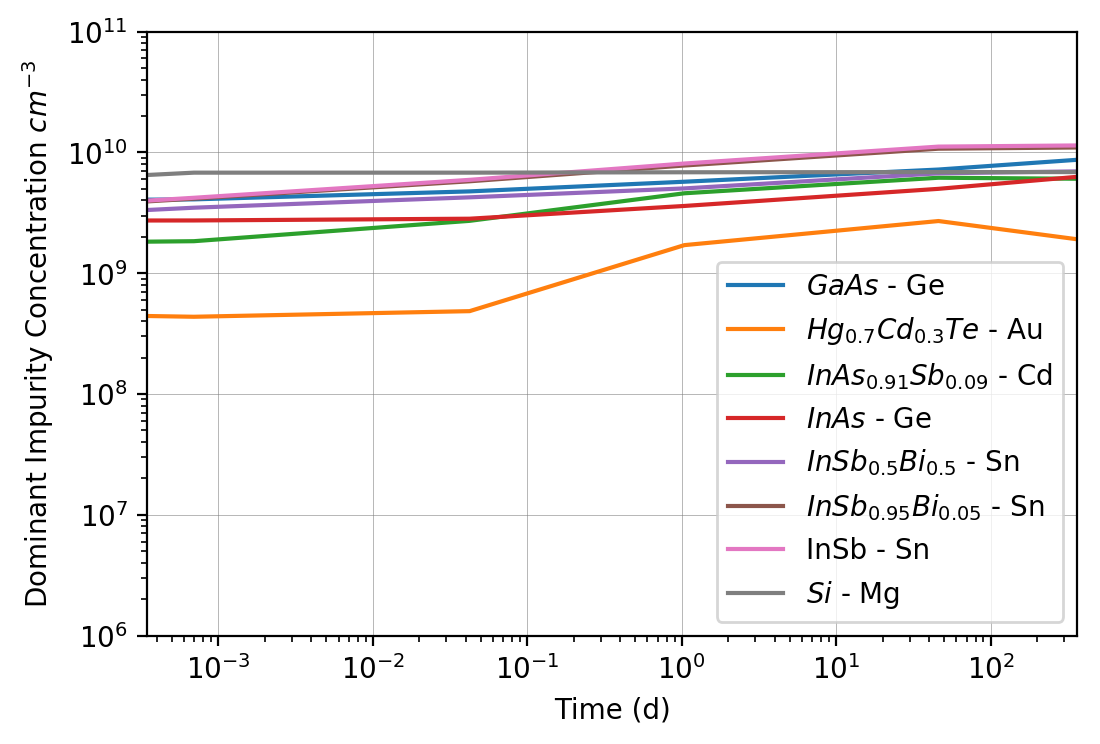

In [177]:
nice_semiconductor_names = numpy.array(['$GaAs$' , '$Hg_{0.7}Cd_{0.3}Te$' , '$InAs_{0.91}Sb_{0.09}$' , '$InAs$' , '$InSb_{0.5}Bi_{0.5}$' , '$InSb_{0.95}Bi_{0.05}$' ,'InSb', '$Si$'])
col_names_sortedForPlot = ['runFile_GaAs.out', 'runFile_HgCdTe.out', 'runFile_InAsSb.out','runFile_InAs.out', 'runFile_InSbBi_5Bi.out',  'runFile_InSbBi_05Bi.out','runFile_InSb.out', 'runFile_Si.out']
sorted_indices = numpy.searchsorted(col_names, col_names_sortedForPlot)

max_impurity_10y = max_impurity_at_t[6,:]
delim = numpy.array([' - ',' - ',' - ',' - ',' - ',' - ',' - ',' - '])
appendDash = numpy.core.defchararray.add(delim, max_impurity_10y[sorted_indices])
legend_with_element = numpy.core.defchararray.add(nice_semiconductor_names, appendDash)

times_d = numpy.array(times_s)/(60.0*60*24)

matplotlib.pyplot.figure(dpi=200)

for materialNum, column in enumerate(col_names_sortedForPlot):
    indice = sorted_indices[materialNum]
    matplotlib.pyplot.loglog(times_d[1:], max_impurity_conc_vs_time[1:,indice]*CALC_convertToEXPR_100kRAD_perCM3_45edg)
matplotlib.pyplot.xlabel('Time (d)')
matplotlib.pyplot.xlim([30.0/(24*60*60),365])
matplotlib.pyplot.ylim([10**6,10**11])
matplotlib.pyplot.legend(legend_with_element)
matplotlib.pyplot.ylabel("Dominant Impurity Concentration $cm^{-3}$")
matplotlib.pyplot.grid(b=None, which='major', axis='both', color='grey', linestyle='-', linewidth=.2)
matplotlib.pyplot.show()




In [178]:
print(col_names)
print(max_impurity_at_t)

['runFile_GaAs.out' 'runFile_HgCdTe.out' 'runFile_InAs.out'
 'runFile_InAsSb.out' 'runFile_InSb.out' 'runFile_InSbBi_05Bi.out'
 'runFile_InSbBi_5Bi.out' 'runFile_Si.out']
[['Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si']
 ['Ge' 'Tl' 'Sn' 'Sn' 'Sn' 'Sn' 'Po' 'Mg']
 ['Ge' 'Tl' 'Sn' 'Sn' 'Sn' 'Sn' 'Po' 'Mg']
 ['Zn' 'I' 'Sn' 'Sn' 'Sn' 'Sn' 'Sn' 'Mg']
 ['Zn' 'I' 'Cd' 'Cd' 'Sn' 'Sn' 'Sn' 'Mg']
 ['Zn' 'Au' 'Cd' 'Cd' 'Sn' 'Sn' 'Sn' 'Mg']
 ['Ge' 'Au' 'Ge' 'Cd' 'Sn' 'Sn' 'Sn' 'Mg']]
